#**Compressive Domain Analytics**

Carrying necessary imports.

In [ ]:
# !pip install torch_xla
# Required for tpu processing

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.autograd as tag

# import torch_xla # for using tpu
# import torch_xla.core.xla_model as xm

**DataLoader** and **Download** helper function

returns a dictionary of train,test dataloaders with class list.

In [ ]:
def get_big_cifar10_data(augmentation=0, root_dir = './data'):
  # Data augmentation transformations. Not for Testing!
    if augmentation:
        transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from 136x136 padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.ToTensor()

    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(root= root_dir, train=True, download=True,
                                            transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                            num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=root_dir, train=False, download=True,
                                        transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                            num_workers=2)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return {'train': trainloader, 'test': testloader, 'classes': classes}


Custom Defined **Quantize Layer** for efficiently transmitting data at lower bit rate.

In [ ]:
class QuantizeFunction(tag.Function):

    @staticmethod
    def forward(ctx, tensor, qp=0.5, normalize=True):
        ctx.qp = qp
        ctx.normalize = normalize
        if normalize == True:
            output = qp*torch.round(tensor/qp)
        else:
            output = torch.round(tensor/qp)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.normalize == True:
            grad_input = grad_output.clone()
        else:
            grad_input = grad_output.clone()/ctx.qp
        return grad_input, None, None

class QuantizeLayer(torch.nn.Module):
    """
        Custom defined.
    """
    def __init__(self, qp=0.5, normalize=True):
        super(QuantizeLayer, self).__init__()
        self.qp = qp
        self.normalize = normalize

    def forward(self, input):
        return QuantizeFunction.apply(input, self.qp, self.normalize)

Train function for **maximizing the zeros** in activation of **QuantizeLayer()**

In [ ]:

def train_on_quantize(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=100, state=None, schedule={}, checkpoint_path=None):

  net.to(device)
  net.train()

# To store the losses for plotting purpose
  losses = []

# Set 'L2 norm' as criteria
  rate_criterion = nn.MSELoss()

# Stochastic Gradient Descend
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state (Not Required for this model )
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

# TRAINING START
  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad() #1

        outputs = net.layer2[1](net.layer1(net.maxpool(net.relu(net.bn1(net.conv1(inputs))))))

        # RATE LOSS
        # Approach: Compute the L2-Norm with zero tensor(our target in this case)
        # Backpropogation will lead to increasing the no of zeros in activation of QuantizeLayer()
        rate_loss = rate_criterion(outputs, torch.zeros_like(outputs))

        rate_loss.backward()

        if( device == 'cuda:0' or device == 'cpu'):
            optimizer.step()
        else:
            xm.optimizer_step(optimizer= optimizer) # takes a step in gradient direction


        losses.append(rate_loss.item())
        sum_loss += rate_loss.item()

        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.5f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0

    print("EPOCH ", epoch)
    print(" Training Accuracy is: " , accuracy(net ,  dataloader) , end= "|")
    c,t = no_of_zeros( net , dataloader)
    print(" Zeros: ",c , " total: ", t , " Ratio: ",  c/t  )
    print( "Testing Accuracy is: ", accuracy(net , big_cifar_data['test']), end = "\n\n")

    if checkpoint_path: #(Not required for this case)
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

  return losses

Train function for **classification task** for training after QuantizeLayer().

In [ ]:

def train_after_quantize(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=100, state=None, schedule={}, checkpoint_path=None):

  net.to(device)
  net.train()

# To store the losses for plotting purpose
  losses = []

# Set 'L2 norm' as criteria
  task_criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descend
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state (Not Required for this model )
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

# TRAINING START
  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad() #1

        outputs = net(inputs)

        # TASK LOSS
        # Approach: Classification using categorical cross entropy.
        task_loss = task_criterion(outputs, labels)

        task_loss.backward()

        # if( device == 'cuda:0' or device == 'cpu'):
        optimizer.step()
        # else:
        #     xm.optimizer_step(optimizer= optimizer) # takes a step in gradient direction


        losses.append(task_loss.item())
        sum_loss += task_loss.item()

        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.5f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0

    print("EPOCH ", epoch)
    print(" Training Accuracy is: " , accuracy(net ,  dataloader) , end= "|")
    # c,t = no_of_zeros( net , dataloader)
    # print(" Zeros: ",c , " total: ", t , " Ratio: ",  c/t  )
    print( "Testing Accuracy is: ", accuracy(net , big_cifar_data['test']), end = "\n\n")

    if checkpoint_path: #(Not required for this case)
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

  return losses

Train Function for combined rate loss and task loss

**loss = Lt + (lambda)*Lr**

In [ ]:
def train_regularized(net, dataloader, epochs=1, lmbda= 0.1 , start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=100, state=None, schedule={}, checkpoint_path=None):

#   send the network to device and set it to training mode
  net.to(device)
  net.train()

# Lt (Task Loss) -> CrossEntropyLoss and Lr (Rate Loss) -> Mean Squared Error Loss
  losses = []
  task_criterion = nn.CrossEntropyLoss()
  rate_criterion = nn.MSELoss()

# Stochastic Gradient Descend
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

# Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

# Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):

    print("EPOCH ", epoch)
    sum_loss = 0.0
    sum_rate = 0.0
    sum_task = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    # BATCH TRAINING
    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad() # 1

        outputs = net(inputs)
        temp = net.layer2[1](net.layer1(net.maxpool(net.relu(net.bn1(net.conv1(inputs))))))

        task_loss = task_criterion(outputs, labels)
        rate_loss = rate_criterion(temp , torch.zeros_like(temp))

        loss_total = task_loss + (lmbda)*rate_loss # loss = Lt + (lambda)*Lr

        loss_total.backward()  # autograd magic, computes all the partial derivatives

        # if( device == 'cuda:0' or device == 'cpu'):
        optimizer.step()
        # else:
        #     xm.optimizer_step(optimizer= optimizer) # takes a step in gradient direction

        losses.append(loss_total.item())
        sum_loss += loss_total.item()
        sum_task += task_loss.item()
        sum_rate += rate_loss.item()

        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.5f' % (epoch, i + 1, sum_loss / print_every))
            #   print( "Lr = " , round(sum_rate/print_every ,4  ), " Lt = " , round( sum_task/ print_every , 4 ) )
            sum_loss = 0.0
            sum_rate = 0.0
            sum_task = 0.0

    print(" Training Accuracy is: " , accuracy(net ,  dataloader) , end= "|")
    c,t = no_of_zeros( net , dataloader)
    print(" Zeros: ",c , " total: ", t , " Ratio: ",  c/t  )
    print( "Testing Accuracy is: ", accuracy(net , big_cifar_data['test']), end = "\n\n")

    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

  return losses

Helper functions for:

1.   Accuracy
2.   Plotting



In [ ]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def no_of_zeros(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net.layer2[1].quant(net.layer2[1].encoder(net.layer1(net.maxpool(net.relu(net.bn1(net.conv1(inputs)))))))
          total += torch.numel(outputs)
          correct +=  (torch.numel(outputs) - torch.count_nonzero(outputs).item())
  return correct, total

def no_of_zeros_new(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net.layer2[1].quant(net.layer2[1].encoder(net.layer1(net.maxpool(net.relu(net.bn1(net.conv1(images)))))))
          total += torch.numel(outputs)
          correct +=  (torch.numel(outputs) - torch.count_nonzero(outputs).item())
  return correct, total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

set device to **cuda:0** if training on GPU

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


if using **tpu** use minor modification

In [ ]:
# device = xm.xla_device()  # Use TPU
# # Use xm.optimizer_step(optimizer= ) for optimizer updates instead of optimizer.step().
# print(device)

# **1. Load Data**

In [ ]:
big_cifar_data = get_big_cifar10_data(augmentation=1 , root_dir= './drive/MyDrive/data' )


Files already downloaded and verified
Files already downloaded and verified


# **2. Load Pretrained Resnet18 Model**

Split Point between Layer1 and Layer2.

In [ ]:
model = torchvision.models.resnet18( pretrained = True )

# Set the output to 10 ( ten-classes classification)
model.fc = nn.Linear(512 , 10 )

# create instance of layer1 and layer2
layer1 = model.layer1
layer2 = model.layer2

# Quantizing Parameter is 1.
quant_layer = QuantizeLayer(qp=1)

# Created a split-point between the laye1 and layer2
model.layer2 = nn.Sequential(layer1 , quant_layer , layer2 )


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **3. Train before Quantize Layer.**

In [ ]:
loss1 = train_on_quantize( model , big_cifar_data['train'] , epochs=2 , lr=0.001 )

[0,   100] loss: 0.50178
[0,   200] loss: 0.50145
[0,   300] loss: 0.50180
EPOCH  0
 Training Accuracy is:  0.10028| Zeros:  1992813818  total:  3276800000  Ratio:  0.6081585137939454
Testing Accuracy is:  0.1006

[1,   100] loss: 0.50098
[1,   200] loss: 0.50115
[1,   300] loss: 0.50047
EPOCH  1
 Training Accuracy is:  0.10058| Zeros:  1992832109  total:  3276800000  Ratio:  0.6081640957641602
Testing Accuracy is:  0.1006



In [ ]:
loss1_contd = train_on_quantize( model , big_cifar_data['train'] , epochs = 2, lr =0.01 )

[0,   100] loss: 0.50190
[0,   200] loss: 0.50140
[0,   300] loss: 0.50171
EPOCH  0
 Training Accuracy is:  0.10052| Zeros:  1991736739  total:  3276800000  Ratio:  0.6078298153686523
Testing Accuracy is:  0.1005

[1,   100] loss: 0.50140
[1,   200] loss: 0.50106
[1,   300] loss: 0.50108
EPOCH  1
 Training Accuracy is:  0.10082| Zeros:  1991722988  total:  3276800000  Ratio:  0.6078256188964843
Testing Accuracy is:  0.1005



In [ ]:
c,t = no_of_zeros( model , big_cifar_data['train'])
print( c ,' ',  t )
c/t

1992841842   3276800000


0.6081670660400391

# **4. Freeze all layers before Quantize Layer.**

Layers include

*   conv1
*   bn1
*   layer1



In [ ]:
for p in model.conv1.parameters():
    p.requires_grad = False

for p in model.bn1.parameters():
    p.requires_grad = False

for p in model.layer1.parameters():
    p.requires_grad = False


# **5. Train after Quantize Layers.**

In [ ]:
loss2 = train_after_quantize(model , big_cifar_data['train'] , epochs= 5 , lr = 0.01 )

In [ ]:
print(" Testing accuracy is : %f " %accuracy(model , big_cifar_data['test']))

 Testing accuracy is : 0.728900 


In [ ]:
print(" Training accuracy is : %f " %accuracy(model , big_cifar_data['train']))

 Training accuracy is : 0.749940 


# **6. Plotting graph for loss over the epochs**

In [ ]:
plt.plot(smooth(loss1 , 50 ))

In [ ]:
plt.plot(smooth(loss2 , 50 ))

# **7. Train Combined. using Lr and Lt**

    next training for epochs = 4 at lr = 0.01


In [ ]:
model_comb = torchvision.models.resnet18( pretrained = True )

# Set the output to 10 ( ten-classes classification)
model_comb.fc = nn.Linear(512 , 10 )

# create instance of layer1 and layer2
layer1 = model_comb.layer1
layer2 = model_comb.layer2

# Quantizing Parameter is 2.
quant_layer = QuantizeLayer(qp=1)

# Created a split-point between the laye1 and layer2
model_comb.layer2 = nn.Sequential(layer1 , quant_layer , layer2 )


In [ ]:
lss = train_regularized( model_comb , big_cifar_data['train'] , epochs = 5 , lr = 0.01 , print_every =100  )

EPOCH  0
[0,   100] loss: 0.78821
[0,   200] loss: 0.39343
[0,   300] loss: 0.35372
 Training Accuracy is:  0.90124| Zeros:  2247549069  total:  3276800000  Ratio:  0.6858975430297851
Testing Accuracy is:  0.8827

EPOCH  1
[1,   100] loss: 0.59317
[1,   200] loss: 0.43584
[1,   300] loss: 0.37420
 Training Accuracy is:  0.90638| Zeros:  2623206186  total:  3276800000  Ratio:  0.8005389971923829
Testing Accuracy is:  0.8921

EPOCH  2
[2,   100] loss: 0.29237
[2,   200] loss: 0.30556
[2,   300] loss: 0.27987
 Training Accuracy is:  0.90462| Zeros:  2659822750  total:  3276800000  Ratio:  0.8117134857177735
Testing Accuracy is:  0.8822

EPOCH  3
[3,   100] loss: 0.25106
[3,   200] loss: 0.24504
[3,   300] loss: 0.23476
 Training Accuracy is:  0.94694| Zeros:  2729132483  total:  3276800000  Ratio:  0.8328651376342774
Testing Accuracy is:  0.9266

EPOCH  4
[4,   100] loss: 0.22435
[4,   200] loss: 0.21259
[4,   300] loss: 0.20726
 Training Accuracy is:  0.9474| Zeros:  2775734818  total:  

In [ ]:
torch.save(model_comb , './drive/MyDrive/model.pth')

In [ ]:
lss = train_regularized( model_comb , big_cifar_data['train'] , epochs = 3 , lmbda=0.1 , print_every =100 )

In [ ]:
c ,t = no_of_zeros(model_comb , big_cifar_data['test'])
# print(c)
print(c/t)

0.8462426834106446


In [ ]:
print("training accuracy : ", accuracy( model_comb , big_cifar_data['train']))
print("testing accuracy : ", accuracy( model_comb , big_cifar_data['test']))


In [ ]:
print(model_comb)

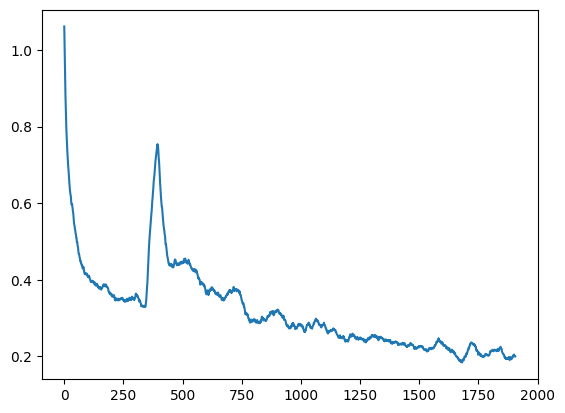

In [ ]:
plt.plot(smooth(lss , 50))

#**Huffmann Coding**

Building the frequency table for huffmann encoding in *data_dic*.

In [ ]:
def huffmann_data_train(net, dataloader):
    dic = {} # an empty dictioinary for huffmann coding
    net.to(device)

    for batch in dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        outputs = net.layer2[1](net.layer1(net.maxpool(net.relu(net.bn1(net.conv1(images))))))
        l = outputs.flatten().tolist()
        for i in l:
            if( dic.get(i) is None):
                dic[i] = 1
            else:
                dic[i]+=1

    return dic

# build data_dict on 'train' data
data_dict = huffmann_data_train(model_comb , big_cifar_data['train'])

# data_dict = {"0.0": 2775722279, "1.0": 472760502, "2.0": 25501475, "3.0": 2514363, "4.0": 252588, "5.0": 40634, "6.0": 6465, "7.0": 1242, "8.0": 264, "9.0": 90, "10.0": 71, "11.0": 18, "12.0": 9, "13.0": 8, "14.0": 7, "15.0": 6}

with open("./drive/MyDrive/dictionary.txt", "w") as outfile:
    json.dump(data_dict , outfile )


In [ ]:
import json

with open('./drive/MyDrive/dictionary.txt' , 'r') as f :
    data_dic = json.load(f)

model = torch.load('./drive/MyDrive/model.pth') # a model with 94% accuracy


{'0.0': 2775722279, '1.0': 472760502, '2.0': 25501475, '3.0': 2514363, '4.0': 252588, '5.0': 40634, '6.0': 6465, '7.0': 1242, '8.0': 264, '9.0': 90, '10.0': 71, '11.0': 18, '12.0': 9, '13.0': 8, '14.0': 7, '15.0': 6}


**BPP Computation**

In [ ]:
# define hoff module at "./drive/MyDrive/huffmann_encoding"
import hoff as he

c1, c2 = 0, 0
bpp = 0
for batch in big_cifar_data['train']:

    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model.layer2[1](model.layer1(model.maxpool(model.relu(model.bn1(model.conv1(images))))))
    the_data = outputs.flatten().tolist()
    encoding, treehead , c1 , c2  = he.HuffmanEncoding( the_data, train_dic = data_dic)

    break

bpp = c2/(128*3*128*128)
print( "Earlier required bpp was : " , 8 )
print("BPP is  " , bpp)

Space usage before compression (in bits): 67108864
Space usage after compression (in bits): 9719988
Earlier required bpp was :  8
BPP is   1.5449504852294922


# **Test with VAE layer for encoding.**

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(2048*2, 200)
        self.z_log_var = torch.nn.Linear(2048*2, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 2048*2),
                Reshape(-1, 64, 8, 8),
                #
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.Conv2d(64, 64, stride=1, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.Conv2d(64, 64, stride=1, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.Conv2d(64, 32, stride=1, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.Conv2d(32, 3, stride=1, kernel_size=3, padding=1),
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
vae = VAE()
vae.load_state_dict(torch.load('./drive/MyDrive/vae_on_cifar_data.pth'))

<All keys matched successfully>

In [ ]:
# Freeze all layers with its parameters
for p in vae.parameters():
    p.requires_grad = False

In [ ]:
model_cifar = torch.load('./drive/MyDrive/model_forkd.pth')

In [ ]:
print( "Acuracy of model " , accuracy(model_cifar , big_cifar_data['train']))

Acuracy of model  0.96602


In [ ]:
class optimized_model(nn.Module):

    def __init__(self) :
        super().__init__()

        self.vae_layer = vae
        self.model_cifar = model_cifar

    def forward(self , x ):

        # encoded, z_mean, z_log_var, decoded_images = self.vae_layer(x)
        return model_cifar(self.vae_layer(x)[3])



In [ ]:
nu = optimized_model()


In [ ]:
print( "Accuracy :" , accuracy(nu , big_cifar_data['train']))

Accuracy : 0.24912


In [ ]:
print( vae(          torch.rand( [1 , 3, 128 , 128 ]).cuda()    )[1])

In [ ]:
for p in nu.parameters():
    print(p.requires_grad)

In [ ]:
lssos = train_after_quantize( nu , big_cifar_data['train'] , epochs = 7 , lr = 0.001 , print_every = 100)

[0,   100] loss: 0.85671
[0,   200] loss: 0.81056
[0,   300] loss: 0.75649
EPOCH  0
 Training Accuracy is:  0.75866|Testing Accuracy is:  0.7379

[1,   100] loss: 0.69410
[1,   200] loss: 0.68126
[1,   300] loss: 0.69036
EPOCH  1
 Training Accuracy is:  0.7579|Testing Accuracy is:  0.7357

[2,   100] loss: 0.67559
[2,   200] loss: 0.66036
[2,   300] loss: 0.67250
EPOCH  2
 Training Accuracy is:  0.76766|Testing Accuracy is:  0.744

[3,   100] loss: 0.65037
[3,   200] loss: 0.63983
[3,   300] loss: 0.65242
EPOCH  3
 Training Accuracy is:  0.7704|Testing Accuracy is:  0.7389

[4,   100] loss: 0.62942
[4,   200] loss: 0.64449
[4,   300] loss: 0.64367
EPOCH  4
 Training Accuracy is:  0.77748|Testing Accuracy is:  0.7483

[5,   100] loss: 0.62115
[5,   200] loss: 0.64060
[5,   300] loss: 0.63241
EPOCH  5
 Training Accuracy is:  0.77912|Testing Accuracy is:  0.7488

[6,   100] loss: 0.60975
[6,   200] loss: 0.61718
[6,   300] loss: 0.64265
EPOCH  6
 Training Accuracy is:  0.77772|Testing Acc

In [ ]:
lssos = train_after_quantize( nu , big_cifar_data['train'] , epochs = 7 , lr = 0.0001 , print_every = 100)

[0,   100] loss: 0.72051
[0,   200] loss: 0.70064
[0,   300] loss: 0.70593
EPOCH  0
 Training Accuracy is:  0.7772|Testing Accuracy is:  0.7459

[1,   100] loss: 0.62751
[1,   200] loss: 0.62604
[1,   300] loss: 0.61255
EPOCH  1
 Training Accuracy is:  0.78408|Testing Accuracy is:  0.7512

[2,   100] loss: 0.59095
[2,   200] loss: 0.62167
[2,   300] loss: 0.60542
EPOCH  2
 Training Accuracy is:  0.78678|Testing Accuracy is:  0.7531

[3,   100] loss: 0.60462
[3,   200] loss: 0.59970
[3,   300] loss: 0.61081
EPOCH  3
 Training Accuracy is:  0.78578|Testing Accuracy is:  0.754

[4,   100] loss: 0.59859
[4,   200] loss: 0.59071
[4,   300] loss: 0.61003
EPOCH  4
 Training Accuracy is:  0.7879|Testing Accuracy is:  0.7542

[5,   100] loss: 0.60048
[5,   200] loss: 0.59381
[5,   300] loss: 0.60128
EPOCH  5
 Training Accuracy is:  0.78674|Testing Accuracy is:  0.7527

[6,   100] loss: 0.59026
[6,   200] loss: 0.60231
[6,   300] loss: 0.59571
EPOCH  6
 Training Accuracy is:  0.78808|Testing Acc

In [ ]:
flssos = train_after_quantize( nu , big_cifar_data['train'] , epochs = 7 , lr = 0.0001 , print_every = 100)

NameError: name 'train_after_quantize' is not defined